In [1]:








import os
from os.path import dirname, abspath
import sys
import random
import math
import re
import time
import datetime
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('QT5Agg')
from PIL import Image
from cucu_utils import *
import json
from cocoapi.PythonAPI.pycocotools.coco import COCO
from cocoapi.PythonAPI.pycocotools import mask as maskUtils



debugFlag=False
if debugFlag:
    # DEBUG MODE:
    ROOT_DIR = dirname(dirname(os.path.realpath(__file__)))
    print(ROOT_DIR)
else:
    # Root directory of the project
    ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

#asher todo: change later to path inside cucu_train
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "cucu_train/weightsAndGraphs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
  








/home/simon/anaconda3/envs/cucuEnv/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/simon/anaconda3/envs/cucuEnv/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/simon/anaconda3/envs/cucuEnv/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/simon/anaconda3/envs/cucuEnv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/simon/anaconda3/envs/cucuEnv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/simon/anaconda3/envs/cucuEnv/

In [13]:










class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cucumbers"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    # IMAGES_PER_GPU = 2
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shape (cucumber)

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM =512
    
    # anchor side in pixels, for each of RPN layer
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  
       
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32
    
    #asher todo: can we utilize it better?
    #ROI_POSITIVE_RATIO = 66  
    
    #asher todo: enlarge to 100 when real training occures
    STEPS_PER_EPOCH = 100

    VALIDATION_STEPS = 1
     # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.5
    
config = ShapesConfig()
config.display()



minimum_number_of_cucumbers = 10
maximum_number_of_cucumbers = 120
#number_of_cucumbers = 4
min_scale = 0.4
max_scale = 1.1


############################################################
#  validation Dataset
############################################################

class valCucuDataset(utils.Dataset):
    def __init__(self, folder_objects, folder_bgs):
        """
        self variables:
            folder_object - folder containing object asher todo: what is exactly an object? image +annotations?
            folder_bgs - todo: TBD
            img2 - container for all images in dataSet containing objects
            bg - container for all images in dataSet containing backGrounds
        """
        utils.Dataset.__init__(self)
        
        self.folder_objects = folder_objects
        self.folder_bgs = folder_bgs
        self.img2 = []
        self.bg = []
        # asher todo: temp debug param ->delete
        self.image_counter=0

        for root, _, files in os.walk(self.folder_objects):
            for filename in files:
                #self.img2.append(cv2.cvtColor(cv2.imread(os.path.join(root, filename)), cv2.COLOR_BGR2RGB))
                self.img2.append(Image.open(os.path.join(root, filename)).convert('RGBA'))
        _, _, files_objects = next(os.walk(self.folder_objects))
        self.number_of_cucumbers = len(files_objects)
                
        for root, _, files in os.walk(self.folder_bgs):
            for filename in files:
                #self.bg.append(cv2.cvtColor(cv2.imread(os.path.join(root, filename)), cv2.COLOR_BGR2RGB))
                self.bg.append(Image.open(os.path.join(root, filename)).convert('RGBA'))
        _, _, files_bgs = next(os.walk(self.folder_bgs))
        self.number_of_bgs = len(files_bgs)
        print("folder: " + folder_objects + " inited")
        print("folder: " + folder_bgs + " inited")

    
    def load_shapes(self, count, height, width):
        """
        Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """

        # Add classes
        self.add_class("shapes", 1, "cucumber")
       
        # Add images
        for i in range(count):
            print('Image', i, end='\r')
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None, width=width, height=height, bg_color=bg_color, shapes=shapes)
    
    def load_image(self, image_id):
        """
        for now we only have one shape- cucumber.
        function creates 'collage' bg+one image.

        function is called by load_image_gt - it is crucial for generating on-the-fly training set 
        for NN.
        image_id - associates with certain attributes (image_info) of this image generated 
                   on constructing train_dataset and val_dataset
        """
        info = self.image_info[image_id]
        
        index = random.randint(0, self.number_of_bgs-1) 
        
        # pull some random background from loaded bg set. which are typcally big
        y_topRight, x_topRight,channels = np.asarray(self.bg[index]).shape
        y_max, x_max ,_ = np.asarray(self.bg[index]).shape

        # pick random up-right corner
        x_topRight = random.randint(x_max- config.IMAGE_MAX_DIM , x_max)
        y_topRight = random.randint(y_max- config.IMAGE_MAX_DIM , y_max)

        # pick bottom-left corner for cropping the bg to fir image size which is (config.IMAGE_MAX_DIM)^2
        x_bottomLeft = random.randint(0, x_topRight- config.IMAGE_MAX_DIM)
        y_bottomLeft = random.randint(0, y_topRight- config.IMAGE_MAX_DIM)

        # build random area of configure IMAGE_SHAPE for net, which is IMAGE_MAX_DIM*IMAGE_MAX_DIM
        area = (x_bottomLeft, y_bottomLeft,                 x_bottomLeft+config.IMAGE_MAX_DIM, y_bottomLeft+config.IMAGE_MAX_DIM)
        image = self.bg[index].crop(area)
        
        for shape, location, scale, angle, index in info['shapes']:
            image = self.draw_shape(image, shape, location, scale, angle, index)
        # asher todo: erase it later
        npImage = np.array(image)
        # cv2.imwrite(ROOT_DIR+'/cucu_train/generated_images/img' + str(self.image_counter) + '.png', npImage) 
        self.image_counter+=1
        # remove transparency channel to fit to network data
        ImageWithoutTransparency = npImage[:,:,:3]
        return ImageWithoutTransparency
    
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    
    
    def createMaskedImageByIndex(self, mask, shape, location, scale, angle, index):
        """
        function takes an image from self.img2[index] and pastes it on a given mask
        """
        x_location, y_location = location
        x_scale, y_scale = scale
        
        fig, (ax1, ax2) = plt.subplots(1,2)

        
        img2 = self.img2[index]
        ax1.imshow(img2)

        img1 = mask
        img2 = cv2.resize(img2,None,fx=x_scale, fy=y_scale, interpolation = cv2.INTER_CUBIC)

        # I want to put logo on top-left corner, So I create a ROI
        rows,cols,channels = img2.shape

        #Rotate
        img2 = rotate_bound(img2, angle)

        #ax2.imshow(mask, cmap='gray')
        
        ax2.imshow(img2)

        
        roi = img1[y_location:rows+y_location, x_location:cols+x_location ]

        # Now create a mask of logo and create its inverse mask also
        img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(img2gray, 1, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(mask)
        # Now black-out the area of logo in ROI
        img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
        # Take only region of logo from logo image.
        img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
        # Put logo in ROI and modify the main image
        dst = cv2.add(img1_bg,img2_fg)
        # asher todo: the line of code below won't work: x_offset is not defined
        img1[y_location:rows+y_location, x_offset:cols+x_location ] = dst
        
        x_location, y_location = location
        x_scale, y_scale = scale
        mask = add_image(mask, self.img2[index], x_location, y_location, x_scale, y_scale, angle)
        return mask
    
    def draw_shape_without_transparency(self, image, shape, location, scale, angle, index):
        """
        Draws a shape from the given specs.
        image - is just initiated to zeroes matrix 
        """
        if shape == 'cucumber':
            x_location, y_location = location
            x_scale, y_scale = scale
            image = add_imageWithoutTransparency(image, np.array(self.img2[index]), x_location, y_location, x_scale, y_scale, angle)
        return image


    def draw_shape(self, Collage, shape, location, scale, angle, index):
        """
        Draws another cucumber on a selected background
        Get the center x, y and the size s
        x, y, s = dims
        """
        

        if shape == 'cucumber':
            #print("leaf added")
            #i=0
            x_location, y_location = location
            x_scale, y_scale = scale
            # print(type(self.img2[index]))
            Collage = add_image(Collage, self.img2[index], x_location, y_location, x_scale, y_scale, angle)
        # asher todo: else?
        return Collage
    
    
    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["cucumber"])
        # Color
        # TopLeft x, y
        x_location = random.randint(0, height)
        y_location = random.randint(0, width)
        # Scale x, y
        x_scale = random.uniform(min_scale, max_scale)
        y_scale = random.uniform(min_scale, max_scale)
        # Angle
        angle = random.randint(0, 359)
        # Image index
        index = random.randint(0, self.number_of_cucumbers-1)
        
        return shape, (x_location, y_location), (x_scale, y_scale), angle, index
    
    # asher note: we don't use this func. for now
    def random_image_opencv(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        indexes  = []
        N = random.randint(minimum_number_of_cucumbers, maximum_number_of_cucumbers)
        
        image = np.ones([height, width, 3], dtype=np.uint8)
        
        for _ in range(N):
            shape, location, scale, angle, index = self.random_shape(height, width)
            
            image = add_image(image, self.img2[index], location[0], location[1], scale[0], scale[1], angle)
            y, x, _ = self.img2[index].shape
            
            #shapes.append((shape, color, dims))
            shapes.append((shape, location, scale, angle, index))
            #TODO boxes
            #x, y, s = dims
            #boxes.append([y-s, x-s, y+s, x+s])
            boxes.append([location[1], location[0], location[1] + y, location[0] + x])
            
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes
    
    
    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        indexes  = []
        N = random.randint(minimum_number_of_cucumbers, maximum_number_of_cucumbers)
            
        for _ in range(N):
            shape, location, scale, angle, index = self.random_shape(height, width)
            # asher todo: do we need this?
            #image = add_image(image, self.img2[index], location[0], location[1], scale[0], scale[1], angle)
            #y, x, _ = self.img2[index].shape
            y, x,channels = np.asarray(self.img2[index]).shape
            shapes.append((shape, location, scale, angle, index))
            #TODO boxes
            #x, y, s = dims
            #boxes.append([y-s, x-s, y+s, x+s])
            boxes.append([location[1], location[0], location[1] + y, location[0] + x])
            
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes
    
    def load_mask(self, image_id):
        """
        Generate instance masks for shapes of the given image ID.
        image_id = a key to get atttributes of Collage.
        (a generated image with bg + different objects of different shapes)->(image_info)
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)        

        #asher note: for now itterates only once on cucumber shape
        for i, (shape, location, scale, angle, index) in enumerate(info['shapes']):
            image = np.zeros([info['height'], info['width'], 3], dtype=np.uint8)
            # save in temp for easier inspection if needed
            temp = image_to_mask(self.draw_shape_without_transparency(image, shape, location, scale, angle, index))
            # construct array of masks related to all shapes of objescts in current Collage
            mask[:, :, i] = temp[:,:]
            
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        
        #print(occlusion)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
       
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)        










Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [14]:


############################################################
#  Training Dataset
############################################################

class trainCucuDataset(utils.Dataset):
    def load_cucumber(self,annotations_path, dataset_dir):
        """Load a subset of the COCO dataset.
        dataset_dir: The root directory of the COCO dataset.
        subset: What to load (train, val, minival, valminusminival)
        year: What dataset year to load (2014, 2017) as a string, not an integer
        class_ids: If provided, only loads images that have the given classes.
        class_map: TODO: Not implemented yet. Supports maping classes from
            different datasets to the same class ID.
        return_coco: If True, returns the COCO object.
        auto_download: Automatically download and unzip MS-COCO images and annotations
        """

        # if auto_download is True:
        #     self.auto_download(dataset_dir, subset, year)

        coco = COCO(annotations_path)
        image_dir = "{}".format(dataset_dir)

        # All classes
        class_ids = sorted(coco.getCatIds())

        # All images or a subset?
        if class_ids:
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(coco.getImgIds(catIds=[id])))
            # Remove duplicates
            image_ids = list(set(image_ids))
        else:
            # All images
            image_ids = list(coco.imgs.keys())

        # Add classes
        for i in class_ids:
            self.add_class("coco", i, coco.loadCats(i)[0]["name"])

        # Add images
        for i in image_ids:
            self.add_image(
                "coco", image_id=i,
                path=os.path.join(image_dir, coco.imgs[i]['file_name']),
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))

    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        # If not a COCO image, delegate to parent class.
        # if image_info["source"] != "coco":
        #     return super(trainCucuDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "coco.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(trainCucuDataset, self).load_mask(image_id)

    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m



In [15]:







# Training dataset


dataset_train = trainCucuDataset()
dataset_train.load_cucumber(ROOT_DIR + '/cucu_train/real_annotations/segmentation_results.json',ROOT_DIR + "/cucu_train/real_images_and_annotations")
dataset_train.prepare()




# Validation dataset
if debugFlag:
# DEBUG MODE:
    dataset_val = valCucuDataset( ROOT_DIR + '/cucu_train/object_folder', ROOT_DIR + '/cucu_train/background_folder')
else:
    # REGULAR MODE:
    dataset_val = valCucuDataset('./object_folder','./background_folder')

dataset_val.load_shapes(20, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()






loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
folder: ./object_folder inited
folder: ./background_folder inited


In [ ]:








#show n random image&mask train examples
n = 1
image_ids = np.random.choice(dataset_train.image_ids, n)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, 1)



# # # In[9]:





# w = 16
# h = 16


# n = 1
# image_ids = np.random.choice(dataset_train.image_ids, n)
# for image_id in image_ids:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
    
#     fig = plt.figure(frameon=False, dpi=64)
#     fig.set_size_inches(w,h)

#     ax = plt.Axes(fig, [0., 0., 1., 1.])
#     ax.set_axis_off()
#     fig.add_axes(ax)

#     plt.imshow(image)
#     # fig.savefig('/Users/AsherYartsev/Desktop' + str(image_id) + '.png')
    
    
#     fig = plt.figure(frameon=False, dpi=64)
#     fig.set_size_inches(w,h)

#     ax = plt.Axes(fig, [0., 0., 1., 1.])
#     ax.set_axis_off()
#     fig.add_axes(ax)
    
#     plt.imshow(mask_to_image(mask))
#     # fig.savefig('/Users/AsherYartsev/Desktop' + str(image_id) + '.png')

#     plt.show()
    



# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)








In [ ]:










# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])







In [ ]:










# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
#asher note: each time only one sort of train is possible as for now.
# model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')








In [ ]:








# asher todo: uncomment later when heads training is working
newLearningRate = config.LEARNING_RATE / 5
model.train(dataset_train, dataset_val, learning_rate=newLearningRate, epochs=2, layers="all")








In [ ]:






# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
now = datetime.datetime.now()
model_path = os.path.join(MODEL_DIR, "cucuWheights_" + str(now) + ".h5")
model.keras_model.save_weights(model_path)







In [16]:








class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "cucuWheights_2018-12-18 22:16:13.729956.h5")
# model_path = model.find_last()


# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)







Loading weights from  /home/simon/Mask_RCNN/cucu_train/weightsAndGraphs/cucuWheights_2018-12-18 22:16:13.729956.h5


In [ ]:








# # Test on a random image
# image_id = random.choice(dataset_val.image_ids)
# print(image_id)
# #image_id = 1
# original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names)







Processing 1 images
image                    shape: (183, 275, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
['BG', 'cucumber']
Processing 1 images
image                    shape: (183, 275, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
['BG', 'cucumber']
Processing 1 images
image                    shape: (194, 259, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512

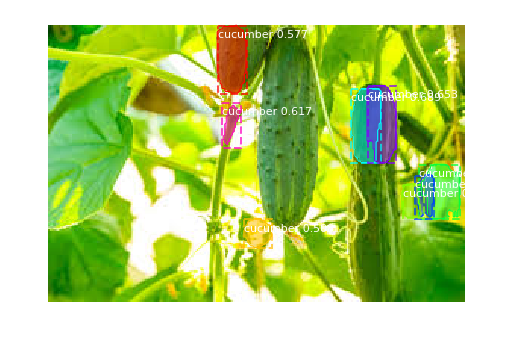

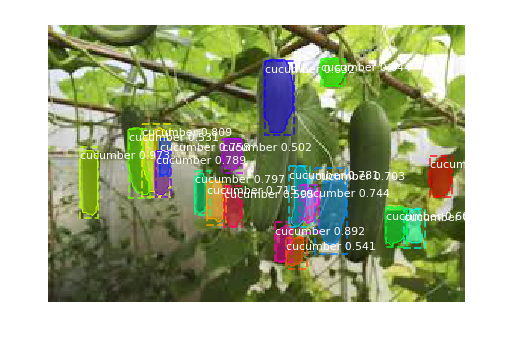

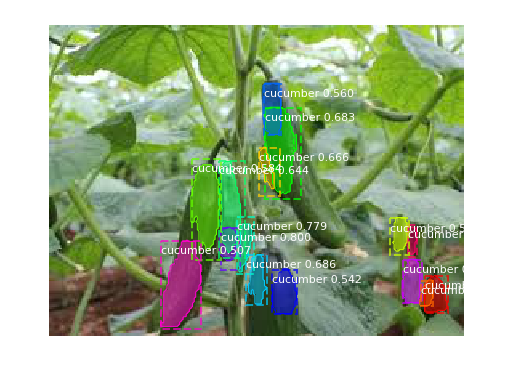

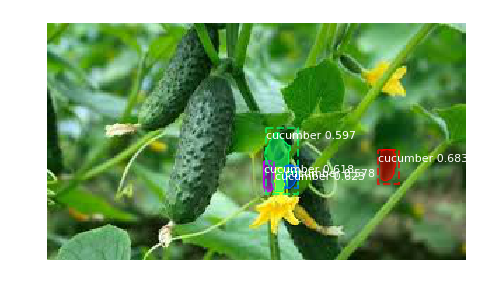

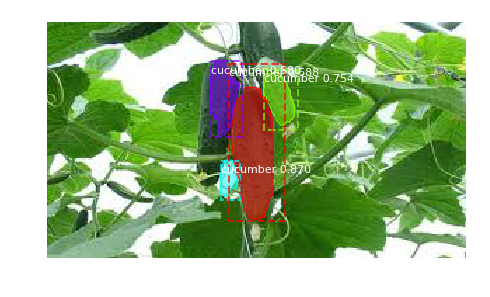

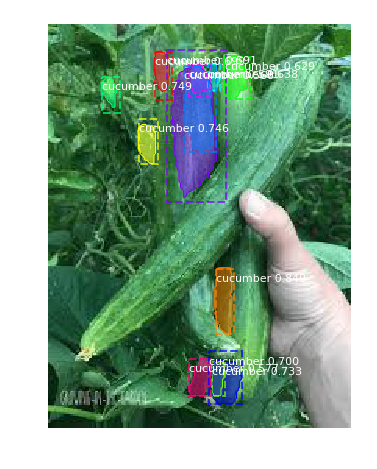

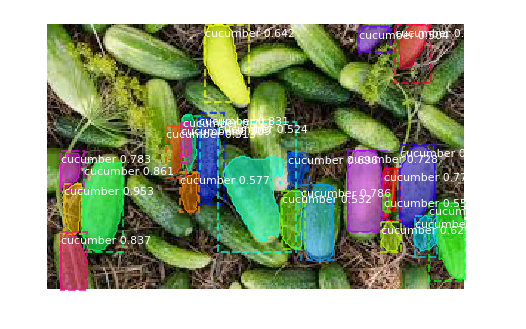

In [17]:






def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


tests_location = ROOT_DIR + "/cucu_train/simple_test/"
for filename in sorted(os.listdir(tests_location)):
    
    testImage = os.path.join(tests_location,filename)
    t = cv2.cvtColor(cv2.imread(testImage), cv2.COLOR_BGR2RGB)
    results = model.detect([t], verbose=1)
    r = results[0]
    visualize.display_instances(t, r['rois'], r['masks'], r['class_ids'] ,dataset_train.class_names, r['scores'], ax=get_ax())
    t= dataset_train.class_names
    print(t)

#asher todo: get inspiration from this later
# # In[28]:


# #from os import walk
# #from os import listdir


# class InferenceConfig(ShapesConfig):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

# inference_config = InferenceConfig()


# model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)
# # Recreate the model in inference mode
# mypath = '/home/simon/Mask_RCNN/cucu_train/weightsAndGraphs'
# mypath_out = '/home/simon/Mask_RCNN/cucu_train/simple_test_OUT'

# # Get path to saved weights
# # Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# #model_path = model.find_last()


# t = cv2.cvtColor(cv2.imread('/home/master/Work/Tensorflow/Project07 - MaskRCNN/data/results/N09/avocado/2018-06-21_AV_leaves_01_1024_02.jpg'), cv2.COLOR_BGR2RGB)
# #original_image.shape



# f = []
# for (dirpath, dirnames, filenames) in walk(mypath):
#    print(os.path.join(mypath,filenames))
#     f.extend(filenames)
#     break
    
# for filename in sorted(os.listdir(mypath)):
    
#     full_name = os.path.join(mypath,filename)
#     # model_path = model.find_by_name(full_name)
#     # Load trained weights
#     print("Loading weights from ", full_name)
#     model.load_weights(model_path=full_name, by_name=True)
    
#     results = model.detect([t], verbose=1)

#     r = results[0]
#     base = os.path.splitext(filename)[0]
#     image_name = base + ".png"
    
#     visualize.save_instances(t, r['rois'], r['masks'], r['class_ids'], dataset_train.class_names, r['scores'], ax=get_ax(), save_to=os.path.join(mypath_out, image_name))


# # In[ ]:


# results = model.detect([original_image], verbose=1)

# r = results[0]
# visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())







In [ ]:








# # Compute VOC-Style mAP @ IoU=0.5
# # Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 100)
# APs = []
# for image_id in image_ids:
#     # Load image and ground truth data
#     image, image_meta, gt_class_id, gt_bbox, gt_mask =        modellib.load_image_gt(dataset_val, inference_config,
#                                image_id, use_mini_mask=False)
#     molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
#     # Run object detection
#     results = model.detect([image], verbose=0)
#     r = results[0]
#     # Compute AP
#     AP, precisions, recalls, overlaps =        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                          r["rois"], r["class_ids"], r["scores"], r['masks'])
#     APs.append(AP)
    
# print("mAP: ", np.mean(APs))





